<a href="https://colab.research.google.com/github/IR04dy/ML-models/blob/main/Mod_Metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import pandas as pd

data = pd.read_csv("creditcard.csv")[:80_000]
data.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [21]:
X = data.drop(columns=["Time", "Amount", "Class"]).values
y = data["Class"].values
f"Shapes of X={X.shape} y={y.shape}, #Fraoud cases{y.sum()}"

'Shapes of X=(80000, 28) y=(80000,), #Fraoud cases196'

In [49]:
from sklearn.linear_model import LogisticRegression

mod = LogisticRegression(class_weight = {0:1, 1:2},max_iter=1000)
mod.fit(X,y).predict(X).sum()

171

In [60]:
from sklearn.model_selection import GridSearchCV

gride = GridSearchCV(estimator=LogisticRegression(max_iter=1000),
                     param_grid={'class_weight':[{0:1, 1:v} for v in range (1,4)]},
                     cv=4, n_jobs=-1)
gride.fit(X,y)

GridSearchCV(cv=4, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=1000, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2},
                                          {0: 1, 1: 3}]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [62]:
pd.DataFrame(gride.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,1.465043,0.292919,0.005003,0.001046,"{0: 1, 1: 1}","{'class_weight': {0: 1, 1: 1}}",0.99405,0.99835,0.99945,0.99780,0.997413,0.002030,1
1,1.362264,0.391003,0.004527,0.000295,"{0: 1, 1: 2}","{'class_weight': {0: 1, 1: 2}}",0.99025,0.99840,0.99960,0.99805,0.996575,0.003697,2
2,1.392871,0.135937,0.004042,0.000737,"{0: 1, 1: 3}","{'class_weight': {0: 1, 1: 3}}",0.98730,0.99845,0.99960,0.99815,0.995875,0.004980,3


In [71]:
from sklearn.metrics import precision_score, recall_score

recall_score(y, gride.predict(X)),precision_score(y, gride.predict(X))

#recall_score: Did i get all the fraud cases? (care about False positive: error increases and will not be affected)
#precision_score: given thati predict fraud, how accurate am i? (care about False negative: If the total of fraud is very small, and all of it was reduced, will not be affected)

(0.5918367346938775, 0.7682119205298014)

In [104]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import numpy as np


def min_recall_precision(est, X, y_true, sample_weight=None):#sample_weight for add your metrics
    y_pred = est.predict(X)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    return min(recall, precision)

grid = GridSearchCV(
    estimator=LogisticRegression(max_iter=1000),
    param_grid={'class_weight': [{0: 1, 1: v} for v in np.linspace(1, 20, 30)]},
    scoring={'precision': make_scorer(precision_score), 
             'recall': make_scorer(recall_score),
             'min_both': min_recall_precision},
    refit='min_both',
    return_train_score=True,
    cv=10,
    n_jobs=-1
)
grid.fit(X, y, sample_weight=np.log(1 + data["Amount"]));

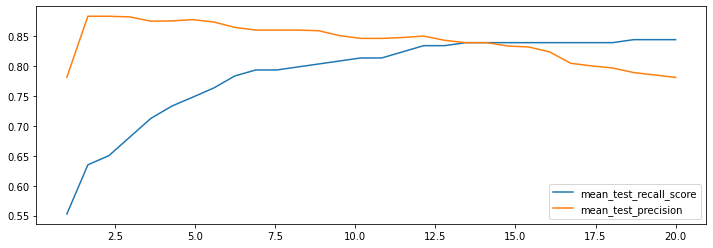

In [125]:
import matplotlib.pylab as plt
plt.figure(figsize=(12, 4))
df_results = pd.DataFrame(gride.cv_results_)
for score in ['mean_test_recall_score', 'mean_test_precision']:
    plt.plot([_[1] for _ in df_results['param_class_weight']], 
             df_results[score], 
             label=score)
plt.legend();
#1.5 class wieght is the best precision
#20 class wieght is the best recall
#14 class wieght is the best in between

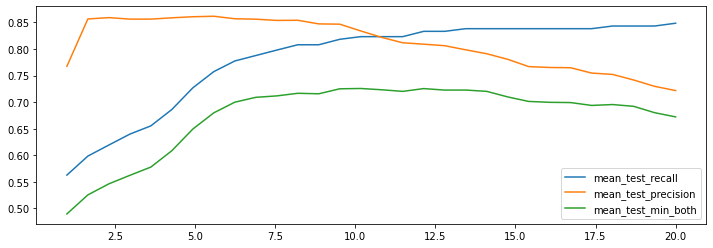

In [116]:

plt.figure(figsize=(12, 4))
df_results = pd.DataFrame(grid.cv_results_)
for score in ['mean_test_recall', 'mean_test_precision', 'mean_test_min_both']:
    plt.plot([_[1] for _ in df_results['param_class_weight']], 
             df_results[score], 
             label=score)
plt.legend();

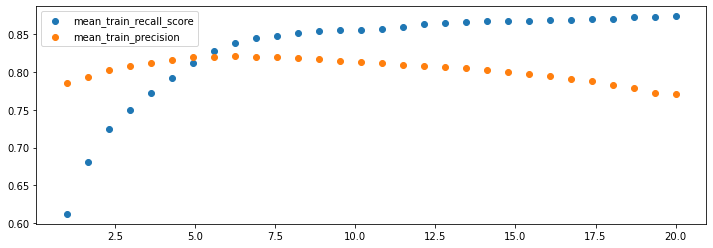

In [126]:
plt.figure(figsize=(12, 4))
df_results = pd.DataFrame(gride.cv_results_)
for score in ['mean_train_recall_score', 'mean_train_precision']:
    plt.scatter(x=[_[1] for _ in df_results['param_class_weight']], 
                y=df_results[score.replace('test', 'train')], 
                label=score)
plt.legend();